In [35]:
import yfinance
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

In [36]:
yfinance.download("EURUSD=X")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EURUSD=X']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,,


In [41]:
def preprocessing_data(symbol):

    #Import data
    df = yfinance.download(symbol).dropna()

    #Rename the columns
    df.columns = ["adj Close", "close",	"High",	"low", "open", "volume"]

    #Remove the adj close columns
    del df["adj Close"]

    return df

df = preprocessing_data("EURUSD=X")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EURUSD=X']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


In [40]:
df.head()

,close,High,low,open,volume
Date,,,,,


In [ ]:
df.shape

(5430, 7)

## Create a trading signal

<Axes: xlabel='Date'>

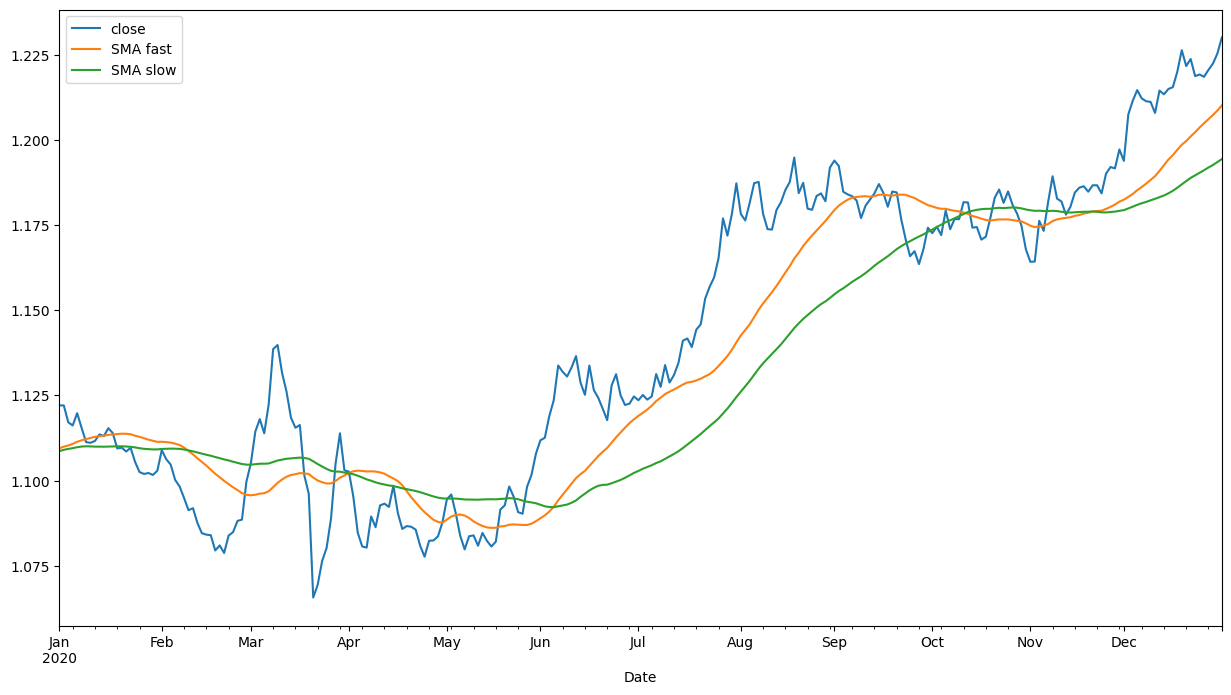

In [20]:
# Create Simple moving average 30 days
df["SMA fast"] = df["close"].rolling(30).mean()

# Create Simple moving average 60 days
df["SMA slow"] = df["close"].rolling(60).mean()

# Plot the results
df[["close", "SMA fast", "SMA slow"]].loc["2020"].plot(figsize=(15,8))

In [22]:
# Create an empty column to put the signal
df["signal"] = np.nan 

# Create the conditions
condition_buy = (df["SMA fast"] > df["SMA slow"] ) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
condition_sell = (df["SMA fast"] < df["SMA slow"] ) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))

df.loc[condition_buy, "signal"] = 1
df.loc[condition_sell, "signal"] = -1

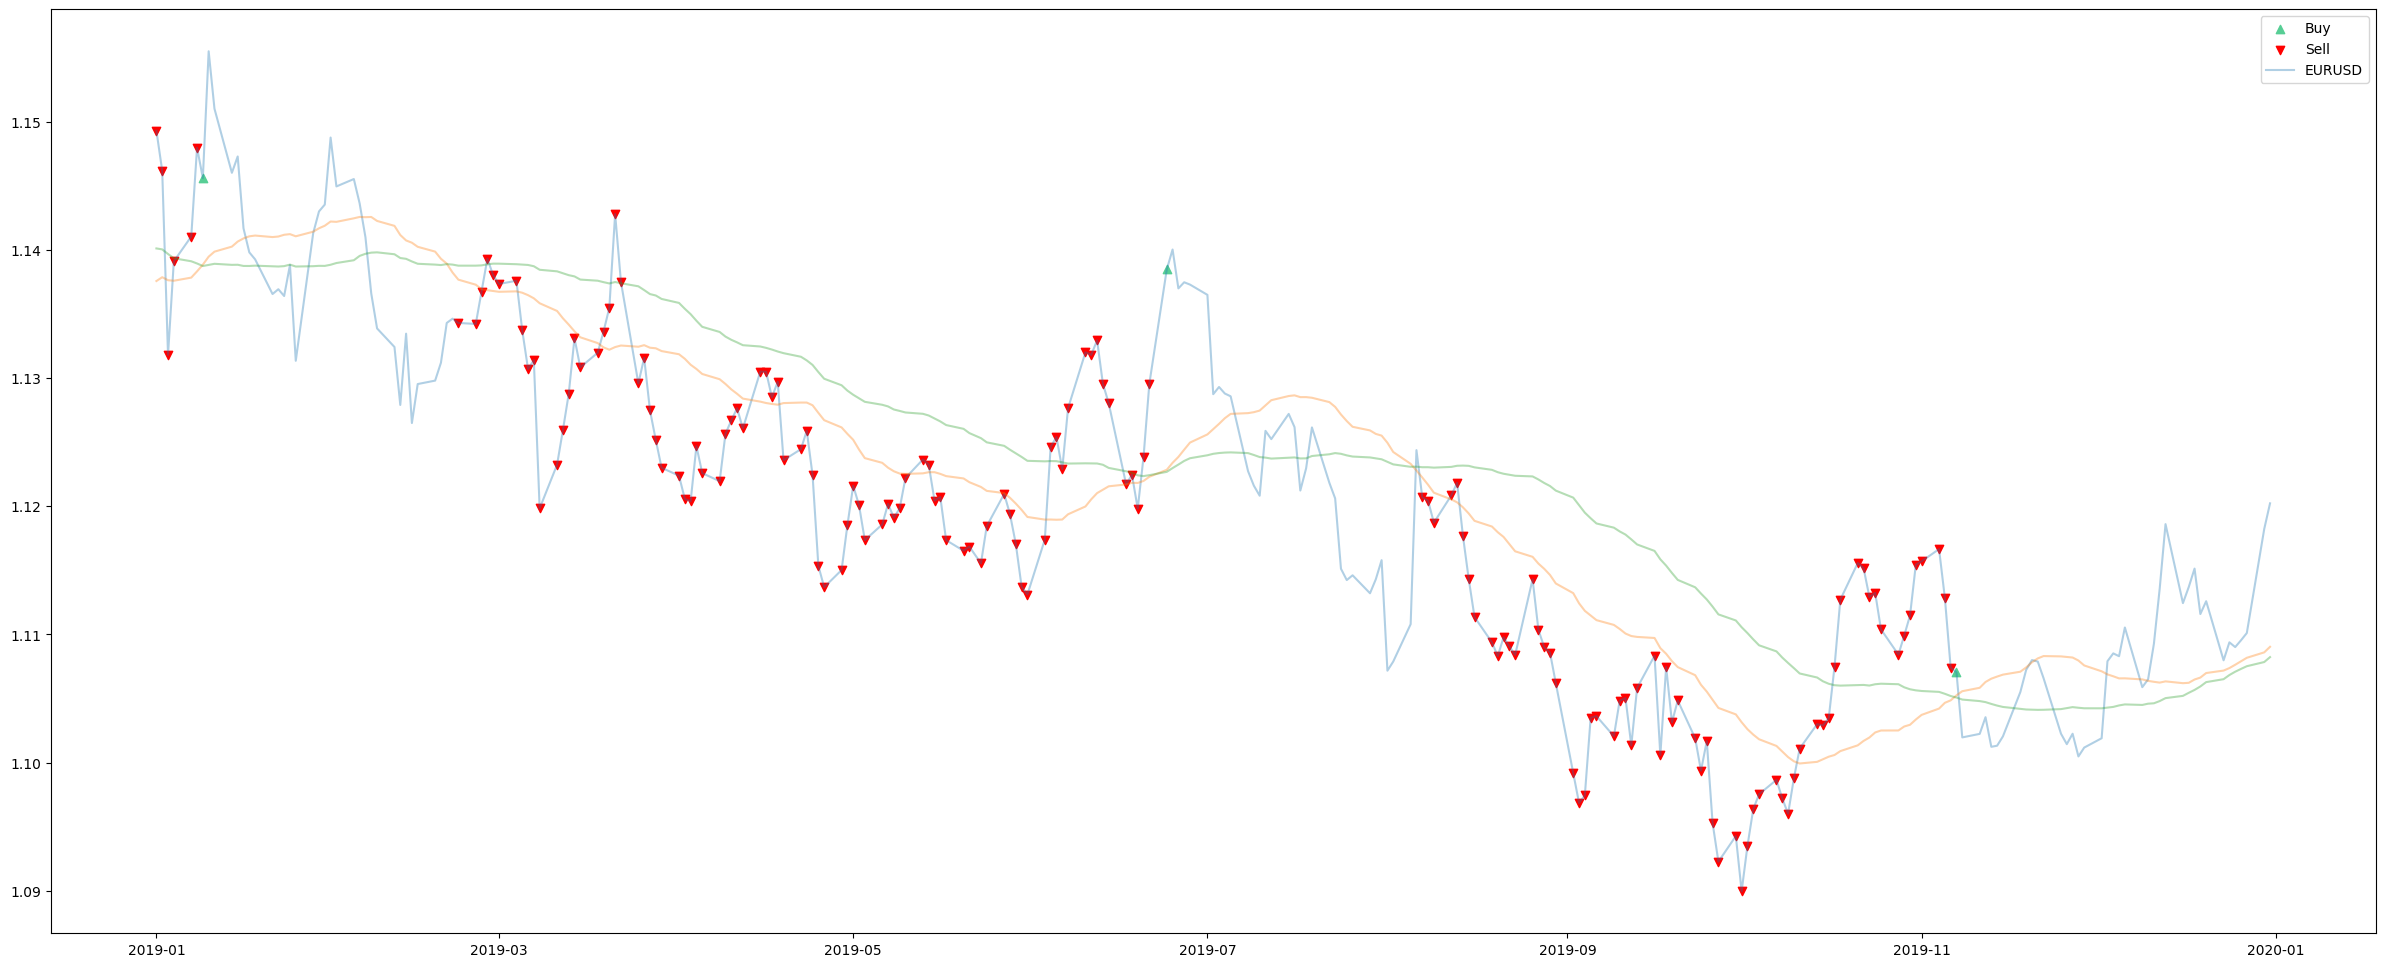

In [ ]:
# We plot all the signla to be sure that they be correct
year="2019"

# Select all signal in a index list to plot only this points
idx_open = df.loc[df["signal"] == 1].loc[year].index
idx_close = df.loc[df["signal"] == -1].loc[year].index

# Adapt the size of the graph
plt.figure(figsize=(30,12))

# Plot the points of the open long signal in green and sell in red
plt.scatter(idx_open, df.loc[idx_open]["close"].loc[year], color= "#57CE95", marker="^")
plt.scatter(idx_close, df.loc[idx_close]["close"].loc[year], color= "red", marker="v")


# Plot the resistance to be sure that the conditions are completed
plt.plot(df["close"].loc[year].index, df["close"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA fast"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA slow"].loc[year], alpha=0.35)

plt.legend(["Buy", "Sell", "EURUSD"])

# Show the graph
plt.show()

## COMPUTE THE PROFIT & LOST (P&L)

#### When you have your trading signals, it's time to see if they are profitable or not

C:\Users\brice\AppData\Local\Temp\ipykernel_17236\1871516412.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["position"] = df["signal"].fillna(method="ffill")


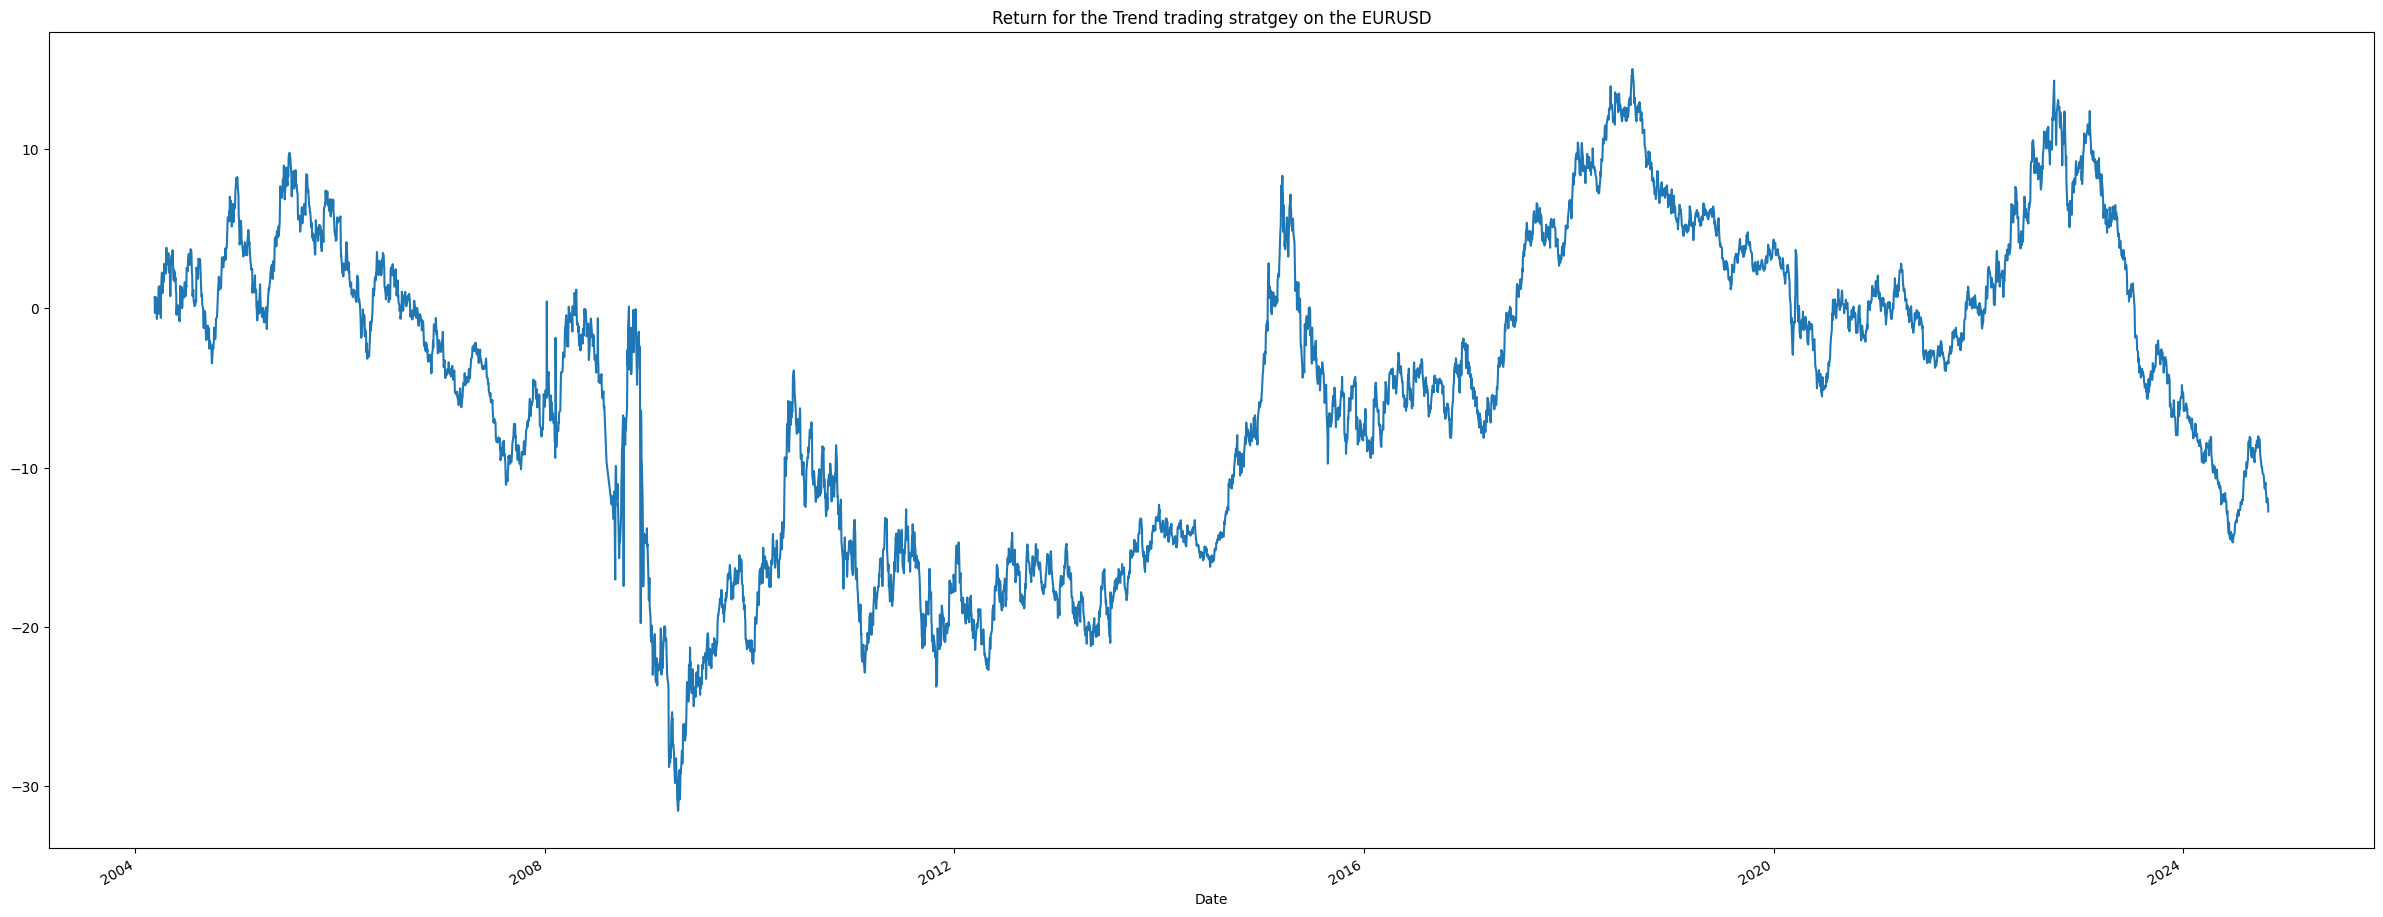

In [ ]:
# We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
df["position"] = df["signal"].fillna(method="ffill") #fill the null value with the last one

# We define a fix cost we need to pay each time we interact with the market
cost_ind = 0.0001

# We create a vector of cost
df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0) #(-0.0001, 0, 0, 0, 0, 0 , 0, -0.0001, 0, 0) (-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,)

# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100


df["return"].cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey on the EURUSD")
plt.show()

In [33]:
def SMA_strategy(input, fast_sma=30, slow_sma=60, cost_ind=0.0001):

  df = preprocessing_data(input)


  # Create Resistance using a rolling max
  df["SMA fast"] = df["close"].rolling(fast_sma).mean()

  # Create Support using a rolling min
  df["SMA slow"] = df["close"].rolling(slow_sma).mean()

  # Create an empty columns to put the signals
  df["signal"]=np.nan

  # Create the condition
  condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
  condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))

  df.loc[condition_buy, "signal"] = 1
  df.loc[condition_sell, "signal"] = -1

  # We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
  df["position"] = df["signal"].fillna(method="ffill")

  # We create a vector of cost
  df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy
  df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100


  return df["return"]

[*********************100%***********************]  1 of 1 completed
C:\Users\brice\AppData\Local\Temp\ipykernel_17236\523053421.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["position"] = df["signal"].fillna(method="ffill")


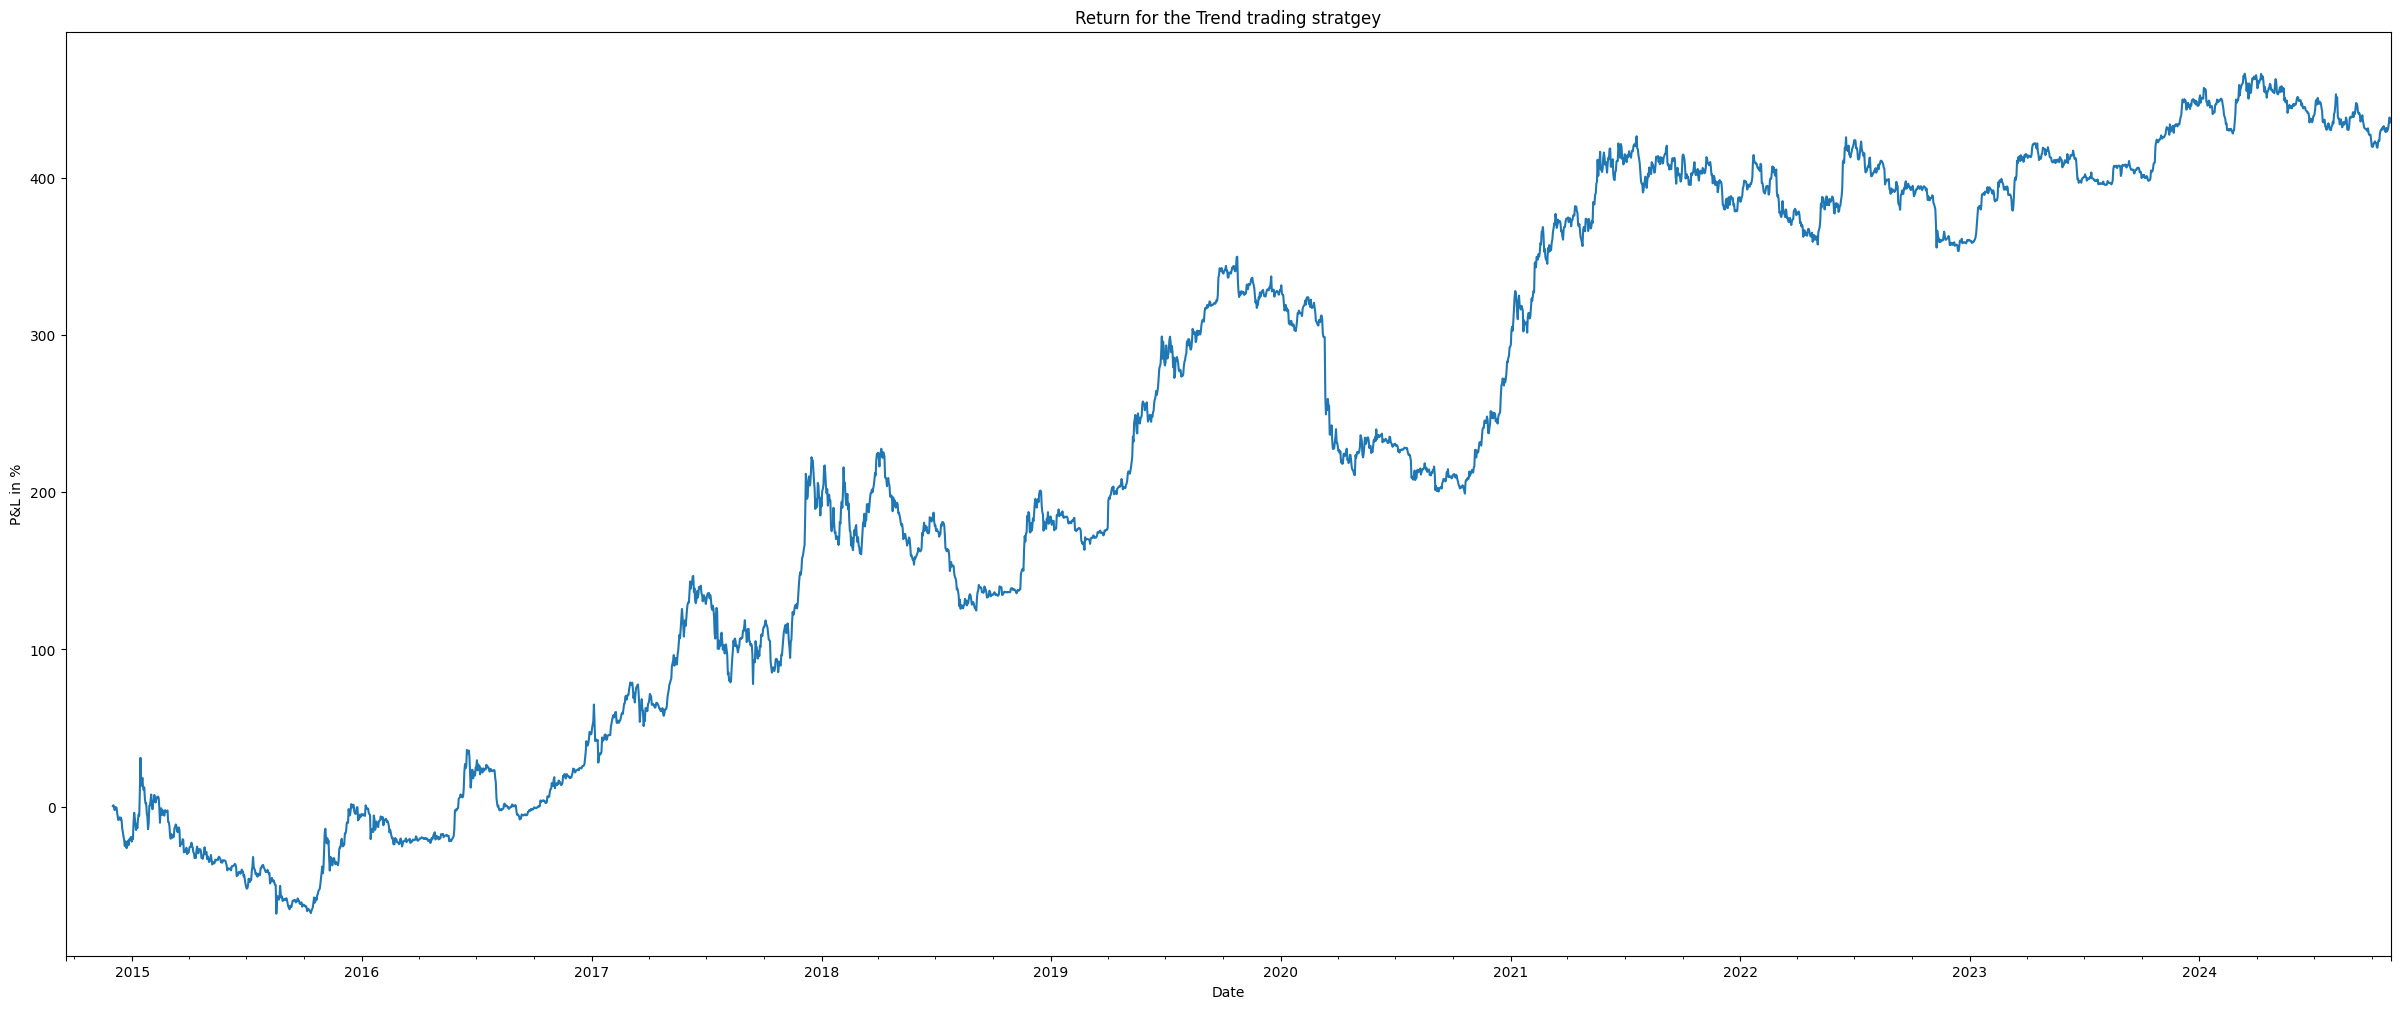

In [34]:
SMA_strategy("BTC-USD", 30,60,0.001).cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey", ylabel="P&L in %")
plt.show()